In [25]:
pip install torch torchvision matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt

In [27]:
# Verify if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set paths to dataset
data_dir = "./dataset/dataset-full"  
output_dir = "./output/full-dataset/vanilla-cnn"

Using device: cuda


In [28]:
# Define data transformations
print("Starting Data Transformations")
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
print("Data Transformations Complete")

Starting Data Transformations
Data Transformations Complete


In [29]:
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [30]:
# Split dataset into training, validation, and test sets
print("Splitting dataset into training, validation, and test sets")
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Splitting dataset into training, validation, and test sets


In [31]:
print("Preparing data loaders")
train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True, num_workers=13, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=13, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False, num_workers=13, pin_memory=True)
print("Finished preparing data loaders")

Preparing data loaders
Finished preparing data loaders


In [32]:
# Define the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Calculate the flattened size after the convolutional layers
        test_input = torch.zeros(1, 3, 200, 200)  # Example input
        conv_output_size = self.conv_layers(test_input).view(1, -1).size(1)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


Convolutional Layers (conv_layers):
    The network has three convolutional blocks:
        Each block includes a convolutional layer (e.g., nn.Conv2d) with ReLU activation and a max pooling layer (nn.MaxPool2d) for downsampling.
    The input channels start at 3 (e.g., for RGB images) and progressively increase to 32, 64, and 128.

Dynamic Flattening Size Calculation:
    To determine the output size of the convolutional layers dynamically, a dummy input tensor of shape
	(1, 3, 200, 200) is passed through self.conv_layers.
    The output is flattened, and its size is computed using .view(1, -1).size(1).

Fully Connected Layers (fc_layers):
    After flattening, the data passes through two fully connected layers (nn.Linear):
        First layer reduces to 128 units with a ReLU activation and a Dropout (50% for regularization).
        Second layer reduces to 1 output with a Sigmoid activation for binary classification.

Output:The model outputs a probability score (range [0, 1]) for binary classification.

In [33]:
print("Starting Model Definition")
model = CNNModel().to(device)
print("Model Definition Complete")


Starting Model Definition
Model Definition Complete


In [34]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
# Update the training loop to record loss and accuracy
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    print("Starting Training Function")
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = correct / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

In [36]:
# Call train_model and store metrics
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=25)

Starting Training Function
Epoch 1, Train Loss: 0.3845, Validation Loss: 0.2290, Validation Accuracy: 0.9103
Epoch 2, Train Loss: 0.2194, Validation Loss: 0.2015, Validation Accuracy: 0.9220
Epoch 3, Train Loss: 0.1836, Validation Loss: 0.1660, Validation Accuracy: 0.9351
Epoch 4, Train Loss: 0.1659, Validation Loss: 0.1463, Validation Accuracy: 0.9433
Epoch 5, Train Loss: 0.1496, Validation Loss: 0.1404, Validation Accuracy: 0.9442
Epoch 6, Train Loss: 0.1454, Validation Loss: 0.1376, Validation Accuracy: 0.9467
Epoch 7, Train Loss: 0.1256, Validation Loss: 0.1346, Validation Accuracy: 0.9484
Epoch 8, Train Loss: 0.1174, Validation Loss: 0.1252, Validation Accuracy: 0.9523
Epoch 9, Train Loss: 0.1085, Validation Loss: 0.1275, Validation Accuracy: 0.9514
Epoch 10, Train Loss: 0.0914, Validation Loss: 0.1317, Validation Accuracy: 0.9516
Epoch 11, Train Loss: 0.0827, Validation Loss: 0.1482, Validation Accuracy: 0.9478
Epoch 12, Train Loss: 0.0732, Validation Loss: 0.1170, Validation Acc

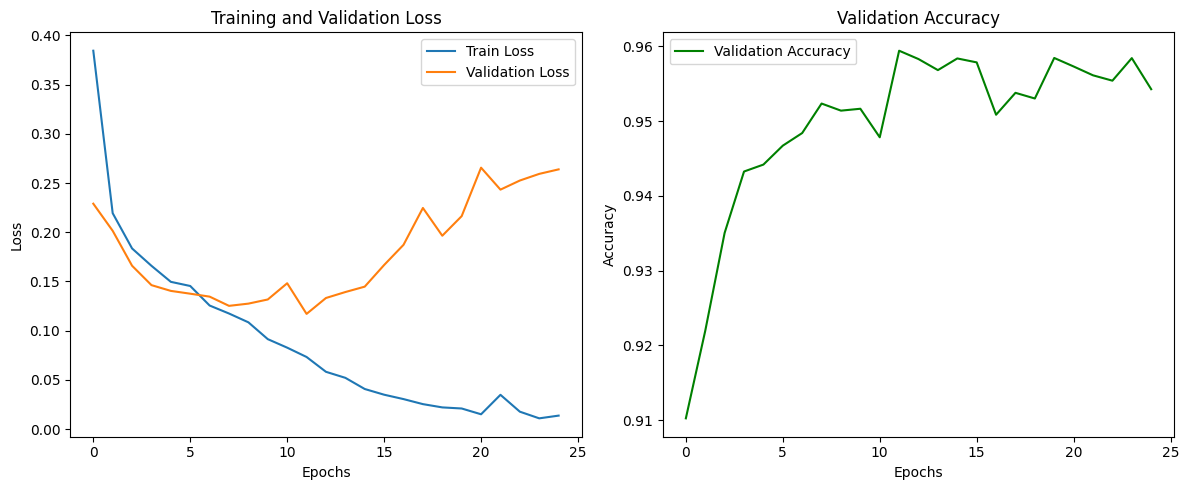

<Figure size 640x480 with 0 Axes>

In [37]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig(f'{output_dir}/training_metrics.png')

Peak Performance:
    The model achieves its best validation performance around Epoch 12:
        Validation Loss: 0.1170
        Validation Accuracy: 95.94%

Overfitting:
    After Epoch 12, the validation loss begins to increase while the training loss continues to decrease, a classic sign of overfitting.
    Example: By Epoch 25, the training loss is very low (0.0137), but the validation loss is much higher (0.2639).

 Generalization:
    The validation accuracy remains relatively high throughout, suggesting the model retains reasonable generalization despite overfitting. However, accuracy fluctuations indicate diminishing returns in later epochs.



In [38]:
# Test the model and plot test accuracy if needed
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return avg_test_loss, test_accuracy

# Call the test_model function
test_loss, test_accuracy = test_model(model, test_loader, device)

Test Loss: 0.2578, Test Accuracy: 0.9530


Generalization:
The model generalizes well to the test data, demonstrating that overfitting (seen in later epochs) did not severely impact the final test performance.

Performance Consistency:
The test accuracy aligns closely with the validation accuracy, confirming that the validation set was representative of the test distribution.

Optimization:
The model achieves high accuracy despite a moderate test loss, indicating effective learning and suitability for the binary classification task.

In [39]:
# Save the model
torch.save(model.state_dict(), f"{output_dir}/full_vanilla_cnn_weights.pth")

print("Model training and testing complete. Model saved.")

Model training and testing complete. Model saved.
